In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
def get_fpaths_from_dir(dirpath):
    fpaths = []
    for root, dirs, files in os.walk(dirpath):
            for name in files:
                fpath = os.path.join(root, name)
                fpaths.append(fpath)
    return fpaths


def plot_simple_map(ax=None, fig=None):
    """
    Plot a simple map with ocean, coastline, rivers, borders, and land.

    Parameters
    ----------
    ax : Axes, optional
        The Axes object to draw on. If not provided, the current Axes will be used.
    fig : Figure, optional
        The Figure object to draw on. If not provided, the current Figure will be used.

    Returns
    -------
    None
    """
    if fig is None:
        fig = plt.gcf()
    if ax is None:
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND)
    gl = ax.gridlines()
    gl.bottom_labels = True
    gl.left_labels = True
    return


def plot_cml_network(df_metadata,
                     lons1_col=None, lons2_col=None,
                     lats1_col=None, lats2_col=None,
                     ax=None, c='b'):

    lonas = ['lons1', 'lons_1', 'lonsa', 'lons_a', 'lona', 'lon_a']
    lonbs = ['lons2', 'lons_2', 'lonsb', 'lons_b', 'lonb', 'lon_b']
    latas = ['lats1', 'lats_1', 'latsa', 'lats_a', 'lata', 'lat_a']
    latbs = ['lats2', 'lats_2', 'latsb', 'lats_b', 'latb', 'lat_b']
    
    dfcols = df_metadata.columns
    
    lona = [i for i in dfcols if i in lonas][0]
    lonb = [i for i in dfcols if i in lonbs][0]
    lata = [i for i in dfcols if i in latas][0]
    latb = [i for i in dfcols if i in latbs][0]
    
    if ax is None:
        ax = plt.gca()
    idxs = df_metadata.index.tolist()
    for idx in idxs:
        lons = df_metadata.loc[idx, lona], df_metadata.loc[idx, lonb]
        lats = df_metadata.loc[idx, lata], df_metadata.loc[idx, latb]
        ax.plot(lons, lats, c=c)
    return


def plot_gauge_network(df, ax=None, display_names=False):
    if ax is None:
        ax = plt.gca()
    # Scatter plot of rain gauge locations
    ax.scatter(df['lon'], df['lat'], c='blue', marker='x', s=50)

    # Iterate over each row in the DataFrame
    if display_names:
        for _, row in df.iterrows():
            name = row['name']
            x, y = row['lon'], row['lat']

            # Adjust text size based on the marker size
            marker_size = 50  # Change this value according to your preference
            text_size = marker_size / 10

            # Calculate the text position offset based on the marker size
            text_offset = marker_size * 0.05

            # Add the text annotation
            ax.annotate(name, (x, y), xytext=(text_offset, -text_offset),
                        textcoords='offset points', fontsize=text_size,
                        ha='left', va='bottom')

    return

In [3]:
cml_paths = get_fpaths_from_dir('data/uruguay/cml_network/')
cml_meta_path = [f for f in cml_paths if 'metadata' in f][0]

cml_csvs_paths = [f for f in cml_paths if not('metadata' in f)]
links_in_dcat = ['_'.join(i.split('/')[-1].split('_')[1:3]) for i in cml_csvs_paths]

cml_metadata = pd.read_csv(cml_meta_path, sep=',', index_col='unique_id', )
cml_metadata = cml_metadata.loc[links_in_dcat, :]

display(cml_metadata.head())

,lon_a,lat_a,lon_b,lat_b,length,freq
unique_id,,,,,,
san_antonio,-57.707965,-31.392939,-57.907157,-31.475068,22.677346,7.0


In [4]:
cml_fpaths_df = pd.DataFrame.from_dict({'unique_id': links_in_dcat,
                                        'path': cml_csvs_paths})

cml_fpaths_df = cml_fpaths_df.set_index('unique_id')

display(cml_fpaths_df.head())

,path
unique_id,
san_antonio,data/uruguay/cml_network/L1_san_antonio_S2017_...


In [5]:
gau_paths = get_fpaths_from_dir('data/uruguay/gauge_network/')
gau_meta_path = [f for f in gau_paths if 'metadata' in f][0]

gau_csvs_paths = [f for f in gau_paths if not('metadata' in f)]
gaus_in_dcat = [i.split('/')[-1].split('_')[1] for i in gau_csvs_paths]

gau_metadata = pd.read_csv(gau_meta_path, sep=',', index_col='unique_id')
gau_metadata = gau_metadata.loc[gaus_in_dcat, :]

display(gau_metadata.head())

,name,lon,lat
unique_id,,,
PS14321,Chacra camio padre pio,-57.89,-31.46
PS14326,Estancia San Antonio,-57.73,-31.41
PS14329,Escuela n66 Tropezon,-57.80,-31.43


In [6]:
gau_fpaths_df = pd.DataFrame.from_dict({'Nom': gaus_in_dcat,
                                        'path': gau_csvs_paths})

gau_fpaths_df = gau_fpaths_df.set_index('Nom')

display(gau_fpaths_df.head())

,path
Nom,
PS14321,data/uruguay/gauge_network/L1_PS14321_S2017_05...
PS14326,data/uruguay/gauge_network/L1_PS14326_S2017_05...
PS14329,data/uruguay/gauge_network/L1_PS14329_S2017_05...


Text(0.5, 1.0, 'CML network links (red) and rain gauges (blue)')

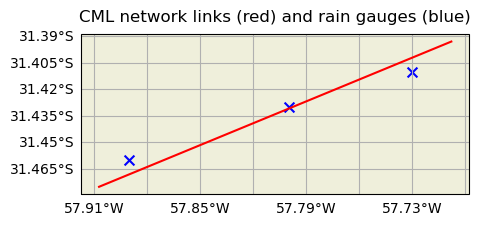

In [7]:
fig = plt.figure(figsize=(5, 7))
plot_simple_map()
plot_cml_network(cml_metadata, c='r')
plot_gauge_network(gau_metadata)
ax = plt.gca()
ax.set_title('CML network links (red) and rain gauges (blue)') 

In [8]:
# let's load a rain link

link_id = cml_metadata.index[0]

print(f'Link in question: {link_id}')

link_df = pd.read_csv(cml_fpaths_df.loc[link_id, 'path'], sep=',', parse_dates=[0], index_col='time')

display(link_df.head())

# let's load a gauge

gauge_id = gau_metadata.index[0]

print(f'Gauge in question: {gauge_id}')

gauge_df = pd.read_csv(gau_fpaths_df.loc[gauge_id, 'path'], sep=',', parse_dates=[0], index_col='time')

display(gauge_df.head())

Link in question: san_antonio


,attenuation
time,
2017-05-18 06:00:00,61.0
2017-05-18 06:01:00,61.3
2017-05-18 06:02:00,61.0
2017-05-18 06:03:00,61.3
2017-05-18 06:04:00,61.0


Gauge in question: PS14321


,acc_precipitation_1min
time,
2017-05-18 06:00:00,0.0
2017-05-18 06:01:00,0.0
2017-05-18 06:02:00,0.0
2017-05-18 06:03:00,0.0
2017-05-18 06:04:00,0.0


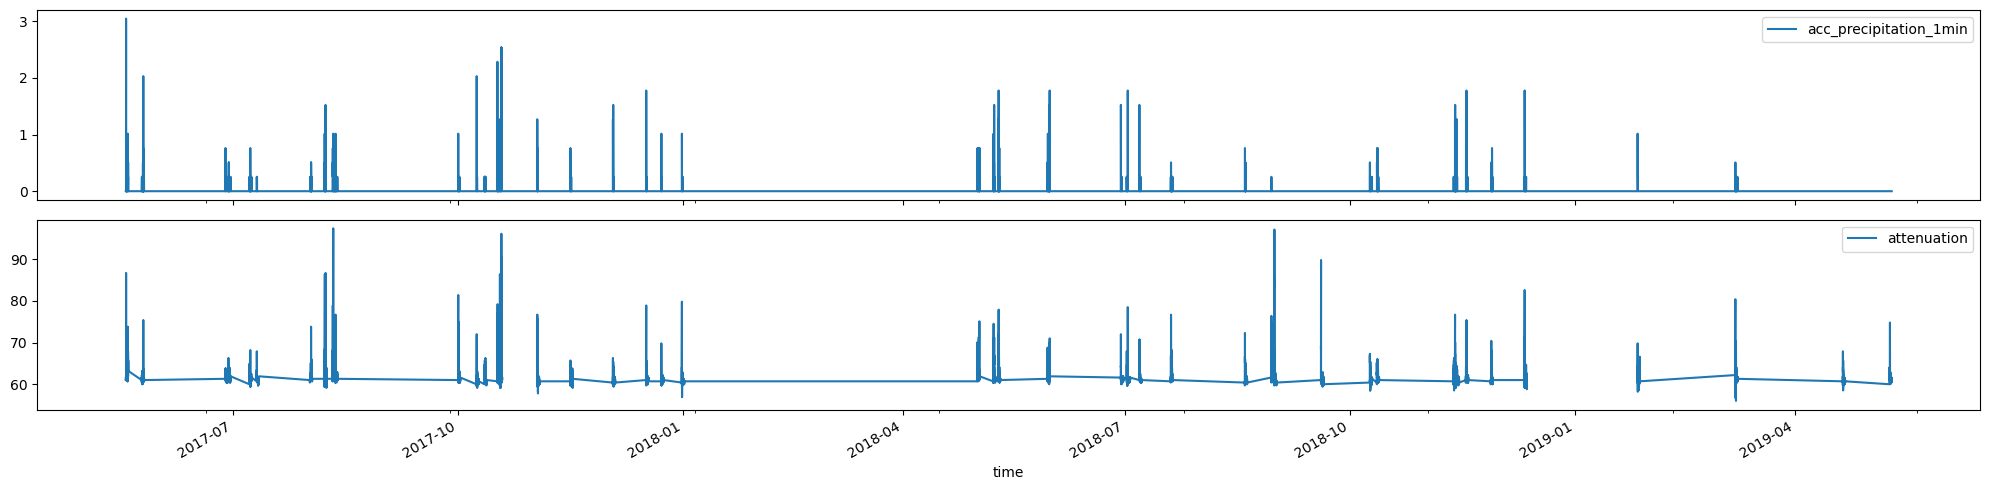

In [9]:
# let's plot them both

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(20, 5))

gauge_df.plot(ax=ax1)
link_df.attenuation.plot(ax=ax2, label='attenuation')
ax2.legend()
plt.tight_layout()

In [10]:
# let's pick a date with significant rain

daily_acc = gauge_df.groupby(pd.Grouper(freq='D')).sum()
above_100mm = daily_acc.loc[daily_acc.acc_precipitation_1min > 100]
display(above_100mm)

date = str(above_100mm.index[0].date())

print(f'Date chose : {date}')

gau_date_df = gauge_df.loc[date]
lin_date_df = link_df.loc[date]

print('Gauge DF')
display(gau_date_df)

print('Link DF')
display(lin_date_df)

,acc_precipitation_1min
time,
2017-10-18,166.116
2018-11-13,168.402


Date chose : 2017-10-18
Gauge DF


,acc_precipitation_1min
time,
2017-10-18 00:00:00,0.0
2017-10-18 00:01:00,0.0
2017-10-18 00:02:00,0.0
2017-10-18 00:03:00,0.0
2017-10-18 00:04:00,0.0
...,...
2017-10-18 23:57:00,0.0
2017-10-18 23:58:00,0.0
2017-10-18 23:58:00,0.0


Link DF


,attenuation
time,
2017-10-18 00:00:00,60.4
2017-10-18 00:01:00,60.4
2017-10-18 00:02:00,60.4
2017-10-18 00:03:00,60.4
2017-10-18 00:04:00,60.4
...,...
2017-10-18 23:57:00,61.9
2017-10-18 23:58:00,61.6
2017-10-18 23:58:00,61.6


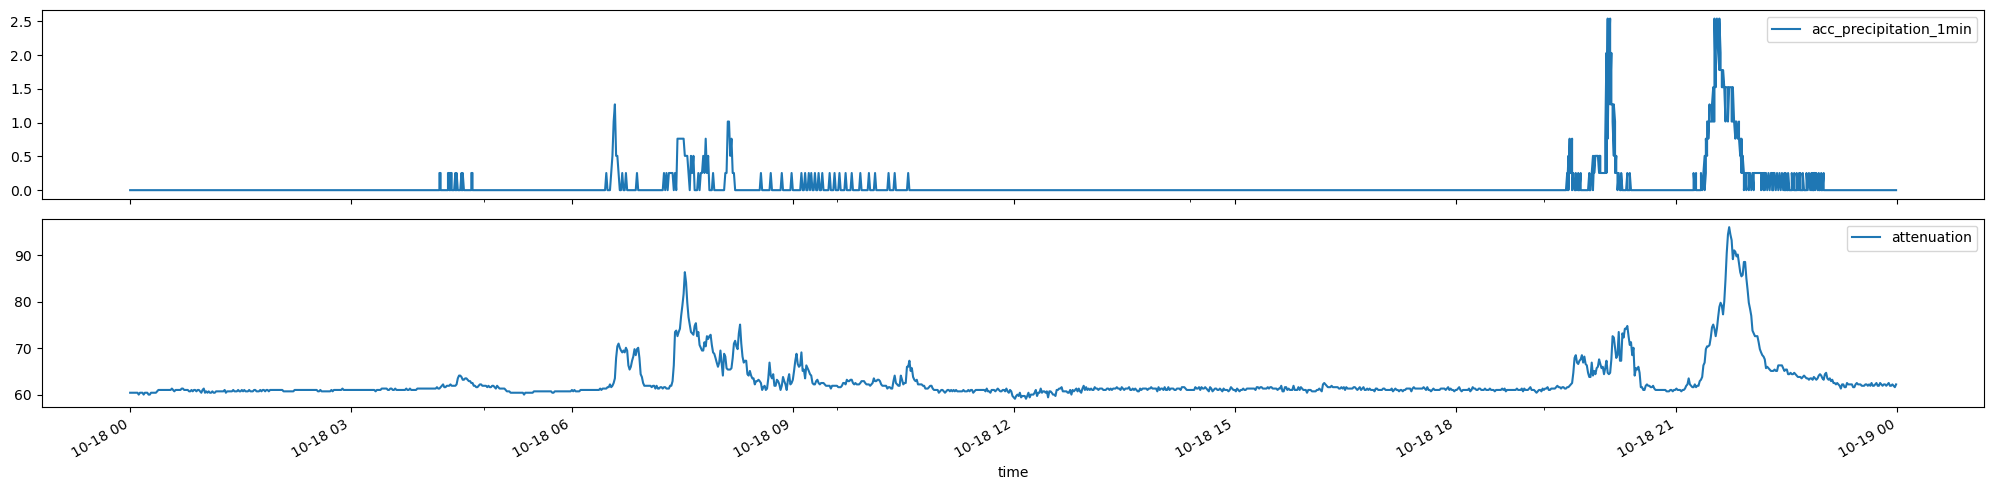

In [11]:
# let's plot them both

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(20, 5))

gau_date_df.plot(ax=ax1)
lin_date_df.attenuation.plot(ax=ax2, label='attenuation')
ax2.legend()
plt.tight_layout()